# **Trabalho Final -  Algoritmos de Machine Learning**
## Este trabalho consiste na utilização de algoritmos de machine learning com a finalidade de criar modelos preditivos que possibilitem extrair padrões ou conhecimento de um dataset, neste utilizamos o dados do IPVA de 2019 a 2022.

### **Universidade Federal do Ceará**

**Equipe:** Francisco Victor da Silva Pinheiro, Maria Inês Vale Silva, Paulina Irene Velasquez Ferrufino e Vaux Sandino Diniz Gomes

**Disciplina:** CKP8277 - APRENDIZAGEM AUTOMÁTICA

**Professor:** Dr. César Lincoln Cavalcante Mattos

### **Sumário:**
#### 1 - Funções utilitárias e importações
#### 2 - Importação do dataset
#### 3 - Pré-processamento dos dados
#### 4 - Regressão logística
#### 5 - K Nearest Neighbor (KNN)
#### 6 - Árvores de Decisão para classificação (CART)
#### 7 - Naïve Bayes - (NB)
#### 8 - Random forest
#### 9 - Catboost
#### 10 - Comparação dos modelos
#### 11 - Experimento Extra com If e Else

### **1 - Funções utilitárias e importações**

In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

svc = SVC(gamma="auto")

Mounted at /content/drive


In [4]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

***Utilitários***

In [5]:
from IPython.display import display_html
from itertools import chain,cycle

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

***Métricas de avaliação***

In [6]:
def accuracy(y_true, y_pred):
    true_positive, true_negative, false_positive, false_negative = calcule_confusion_matrix_values(y_true, y_pred)
    accuracy_rate = (true_positive + true_negative) / y_true.shape[0]
    return accuracy_rate

def recall(y_true, y_pred):
    true_positive, true_negative, false_positive, false_negative = calcule_confusion_matrix_values(y_true, y_pred)
    recall_rate = true_positive / (true_positive + false_negative)
    return recall_rate

def precision(y_true, y_pred):
    true_positive, true_negative, false_positive, false_negative = calcule_confusion_matrix_values(y_true, y_pred)
    precision_rate = true_positive / (true_positive + false_positive)
    return precision_rate

def f1score (y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*(p*r)/(p+r)

***K-fold***

In [7]:
def my_KFold(X, n_splits=3):
  n_samples = X.shape[0]
  num_larger_folds = n_samples % n_splits
  num_default_elements = n_samples // n_splits
  all_index = np.arange(0, n_samples)

  for i in range(0, n_splits):
    if i < num_larger_folds:
        initial_index = i*(num_default_elements+1)
        final_index = initial_index + (num_default_elements+1)
    else:
        initial_index = num_larger_folds*(num_default_elements+1) + (i-num_larger_folds) * num_default_elements
        final_index = initial_index + num_default_elements

    test_index = np.arange(initial_index, final_index)
    train_index = np.setdiff1d(all_index, test_index)

    yield train_index, test_index

In [8]:
def train_model_with_KFold(model, X_train, y_train, n_splits=10):
  index = 1
  df = pd.DataFrame(columns = ["Fold", "Accuracy", "Recall", "Precision", "F1_Score"])

  for train_index, validation_index in my_KFold(X_train, n_splits=n_splits):
    #Treinando o modelo
    model.fit(X_train[train_index], y_train[train_index])

    #Fazendo as previsões nos dados de validação
    y_validation_predictions = model.predict(X_train[validation_index])

    y_validation = y_train[validation_index]

    #Calculando as métricas para os dados de validacao
    acc_score = accuracy(y_validation, y_validation_predictions)
    rec_score = recall(y_validation, y_validation_predictions)
    prec_score = precision(y_validation, y_validation_predictions)
    f_score = f1score(y_validation, y_validation_predictions)

    #Armazenando no dataframe
    df = pd.concat([df, pd.DataFrame([[index, acc_score, rec_score, prec_score, f_score]],columns = ["Fold", "Accuracy", "Recall", "Precision", "F1_Score"] )])
    index+=1
  return df

***Modelo de avaliação***

In [9]:
def diplay_model_evaluation(y_train, y_train_predictions, y_test, y_test_predictions):
  df = pd.DataFrame(columns = ["Dados", "Accuracy", "Recall", "Precision", "F1_Score"])

  acc_score_train = accuracy(y_train, y_train_predictions)
  rec_score_train = recall(y_train, y_train_predictions)
  prec_score_train = precision(y_train, y_train_predictions)
  f_score_train = f1score(y_train, y_train_predictions)

  df = pd.concat([df, pd.DataFrame([['Treino', acc_score_train, rec_score_train, prec_score_train, f_score_train]],\
                                    columns = ["Dados", "Accuracy", "Recall", "Precision", "F1_Score"] )])

  acc_score_test = accuracy(y_test, y_test_predictions)
  rec_score_test = recall(y_test, y_test_predictions)
  prec_score_test = precision(y_test, y_test_predictions)
  f_score_test = f1score(y_test, y_test_predictions)

  df = pd.concat([df, pd.DataFrame([['Teste', acc_score_test, rec_score_test, prec_score_test, f_score_test]],\
                                    columns = ["Dados", "Accuracy", "Recall", "Precision", "F1_Score"] )])

  display(df)

***Matriz de confusão***

In [10]:
def calcule_confusion_matrix_values(y_true, y_pred):
  #Ajustes de dimensões
  if y_true.ndim == 1:
      y_true = y_true.reshape(y_true.shape[0],1)

  if y_pred.ndim == 1:
      y_pred = y_pred.reshape(y_pred.shape[0],1)

  # Funções que vericam se para cada par, temos um true positive,
  # true negative, false positive ou false negative
  tp_vect_func = np.vectorize(lambda x, y: 1 if x == y and x==1 else 0)
  tn_vect_func = np.vectorize(lambda x, y: 1 if x == y and x==0 else 0)
  fp_vect_func = np.vectorize(lambda x, y: 1 if x != y and x==0 else 0)
  fn_vect_func = np.vectorize(lambda x, y: 1 if x != y and x==1 else 0)

  # Contagem dos valores
  TP = np.add.reduce(tp_vect_func(y_true, y_pred))[0]
  TN = np.add.reduce(tn_vect_func(y_true, y_pred))[0]
  FP = np.add.reduce(fp_vect_func(y_true, y_pred))[0]
  FN = np.add.reduce(fn_vect_func(y_true, y_pred))[0]

  return TP, TN, FP, FN

### **2- Importando os dados**

In [11]:
dfParcelasInfoMunicipio = pd.read_csv('./drive/MyDrive/dfParcelasInfoMunicipio (1).csv',delimiter=",",encoding='latin-1')
dfParcelasInfoMunicipioCB = dfParcelasInfoMunicipio
dfParcelasInfoMunicipioTeste = dfParcelasInfoMunicipio
dfParcelasInfoMunicipio.head()

,Unnamed: 0,QtdeVeiculos2019,ValorIPVA2019,ESocioAno2019,InadimplenteAno2019,Parcelado2019,QtdeVeiculos2020,ValorIPVA2020,ESocioAno2020,InadimplenteAno2020,...,ValorIPVA2021,ESocioAno2021,InadimplenteAno2021,Parcelado2021,QtdeVeiculos2022,ValorIPVA2022,ESocioAno2022,InadimplenteAno2022,Parcelado2022,PerCapita
0,314567,1,1646.37,0,0,1,1,1561.62,0,1,...,1469.16,1,0,1,1,1708.47,0,0,1,11245.42
1,221875,2,1860.45,0,0,0,2,1733.90,0,0,...,1615.48,0,0,0,3,2307.21,0,0,1,25254.44
2,266832,1,345.03,0,0,0,1,338.13,0,0,...,331.37,0,0,0,1,445.25,0,0,0,42778.34
3,289537,1,799.65,0,1,1,1,775.48,1,1,...,732.95,1,1,1,1,925.55,1,1,0,19147.09
4,49473,1,878.57,0,1,1,1,861.00,0,1,...,825.30,0,1,0,1,992.08,0,1,0,25254.44


### **3 - Pré-processamento dos dados**

***Converter algumas colunas para variáveis categóricas***

In [12]:
dfParcelasInfoMunicipio['ESocioAno2019']        = dfParcelasInfoMunicipio['ESocioAno2019'].astype('category')
dfParcelasInfoMunicipio['InadimplenteAno2019']  = dfParcelasInfoMunicipio['InadimplenteAno2019'].astype('category')
dfParcelasInfoMunicipio['Parcelado2019']        = dfParcelasInfoMunicipio['Parcelado2019'].astype('category')
dfParcelasInfoMunicipio['ESocioAno2020']        = dfParcelasInfoMunicipio['ESocioAno2020'].astype('category')
dfParcelasInfoMunicipio['InadimplenteAno2020']  = dfParcelasInfoMunicipio['InadimplenteAno2020'].astype('category')
dfParcelasInfoMunicipio['Parcelado2020']        = dfParcelasInfoMunicipio['Parcelado2020'].astype('category')
dfParcelasInfoMunicipio['ESocioAno2021']        = dfParcelasInfoMunicipio['ESocioAno2021'].astype('category')
dfParcelasInfoMunicipio['InadimplenteAno2021']  = dfParcelasInfoMunicipio['InadimplenteAno2021'].astype('category')
dfParcelasInfoMunicipio['Parcelado2021']        = dfParcelasInfoMunicipio['Parcelado2021'].astype('category')
dfParcelasInfoMunicipio['ESocioAno2022']        = dfParcelasInfoMunicipio['ESocioAno2022'].astype('category')
dfParcelasInfoMunicipio['InadimplenteAno2022']  = dfParcelasInfoMunicipio['InadimplenteAno2022'].astype('category')
dfParcelasInfoMunicipio['Parcelado2022']        = dfParcelasInfoMunicipio['Parcelado2022'].astype('category')

# Definir as features (atributos de entrada)
features = ['QtdeVeiculos2019', 'ValorIPVA2019', 'ESocioAno2019', 'Parcelado2019', 'InadimplenteAno2019',
            'QtdeVeiculos2020', 'ValorIPVA2020', 'ESocioAno2020', 'Parcelado2020', 'InadimplenteAno2020',
            'QtdeVeiculos2021', 'ValorIPVA2021', 'ESocioAno2021', 'Parcelado2021', 'InadimplenteAno2021',
            'QtdeVeiculos2022', 'ValorIPVA2022', 'ESocioAno2022', 'Parcelado2022',
            'PerCapita']

# Definir a variável alvo (inadimplente)
target = 'InadimplenteAno2022'

print(dfParcelasInfoMunicipio.dtypes)

# Separar os dados em features e variável alvo
X = dfParcelasInfoMunicipio[features]
y = dfParcelasInfoMunicipio[target]

print(X.shape)
print(y.shape)

# verifica contagem de zeros e uns na variável target
unique, counts = np.unique(y, return_counts=True)
result = np.column_stack((unique, counts))
print(result)

Unnamed: 0                int64
QtdeVeiculos2019          int64
ValorIPVA2019           float64
ESocioAno2019          category
InadimplenteAno2019    category
Parcelado2019          category
QtdeVeiculos2020          int64
ValorIPVA2020           float64
ESocioAno2020          category
InadimplenteAno2020    category
Parcelado2020          category
QtdeVeiculos2021          int64
ValorIPVA2021           float64
ESocioAno2021          category
InadimplenteAno2021    category
Parcelado2021          category
QtdeVeiculos2022          int64
ValorIPVA2022           float64
ESocioAno2022          category
InadimplenteAno2022    category
Parcelado2022          category
PerCapita               float64
dtype: object
(207356, 20)
(207356,)
[[     0 103774]
 [     1 103582]]


***Converter algumas colunas para variáveis object***

In [13]:
# Converter algumas colunas para variáveis categóricas
dfParcelasInfoMunicipioCB['ESocioAno2019']        = dfParcelasInfoMunicipioCB['ESocioAno2019'].astype('int')
dfParcelasInfoMunicipioCB['InadimplenteAno2019']  = dfParcelasInfoMunicipioCB['InadimplenteAno2019'].astype('int')
dfParcelasInfoMunicipioCB['Parcelado2019']        = dfParcelasInfoMunicipioCB['Parcelado2019'].astype('int')
dfParcelasInfoMunicipioCB['ESocioAno2020']        = dfParcelasInfoMunicipioCB['ESocioAno2020'].astype('int')
dfParcelasInfoMunicipioCB['InadimplenteAno2020']  = dfParcelasInfoMunicipioCB['InadimplenteAno2020'].astype('int')
dfParcelasInfoMunicipioCB['Parcelado2020']        = dfParcelasInfoMunicipioCB['Parcelado2020'].astype('int')
dfParcelasInfoMunicipioCB['ESocioAno2021']        = dfParcelasInfoMunicipioCB['ESocioAno2021'].astype('int')
dfParcelasInfoMunicipioCB['InadimplenteAno2021']  = dfParcelasInfoMunicipioCB['InadimplenteAno2021'].astype('int')
dfParcelasInfoMunicipioCB['Parcelado2021']        = dfParcelasInfoMunicipioCB['Parcelado2021'].astype('int')
dfParcelasInfoMunicipioCB['ESocioAno2022']        = dfParcelasInfoMunicipioCB['ESocioAno2022'].astype('int')
dfParcelasInfoMunicipioCB['InadimplenteAno2022']  = dfParcelasInfoMunicipioCB['InadimplenteAno2022'].astype('int')
dfParcelasInfoMunicipioCB['Parcelado2022']        = dfParcelasInfoMunicipioCB['Parcelado2022'].astype('int')

# Definir as features (atributos de entrada)
featuresCB = ['QtdeVeiculos2019', 'ValorIPVA2019', 'ESocioAno2019', 'Parcelado2019', 'InadimplenteAno2019',
            'QtdeVeiculos2020', 'ValorIPVA2020', 'ESocioAno2020', 'Parcelado2020', 'InadimplenteAno2020',
            'QtdeVeiculos2021', 'ValorIPVA2021', 'ESocioAno2021', 'Parcelado2021', 'InadimplenteAno2021',
            'QtdeVeiculos2022', 'ValorIPVA2022', 'ESocioAno2022', 'Parcelado2022',
            'PerCapita']

# Definir a variável alvo (inadimplente)
targetCB = 'InadimplenteAno2022'

print(dfParcelasInfoMunicipioCB.dtypes)

# Separar os dados em features e variável alvo
XCB = dfParcelasInfoMunicipioCB[featuresCB]
yCB = dfParcelasInfoMunicipioCB[targetCB]

print(XCB.shape)
print(yCB.shape)

# verifica contagem de zeros e uns na variável target
unique, counts = np.unique(y, return_counts=True)
result = np.column_stack((unique, counts))
print(result)

Unnamed: 0               int64
QtdeVeiculos2019         int64
ValorIPVA2019          float64
ESocioAno2019            int64
InadimplenteAno2019      int64
Parcelado2019            int64
QtdeVeiculos2020         int64
ValorIPVA2020          float64
ESocioAno2020            int64
InadimplenteAno2020      int64
Parcelado2020            int64
QtdeVeiculos2021         int64
ValorIPVA2021          float64
ESocioAno2021            int64
InadimplenteAno2021      int64
Parcelado2021            int64
QtdeVeiculos2022         int64
ValorIPVA2022          float64
ESocioAno2022            int64
InadimplenteAno2022      int64
Parcelado2022            int64
PerCapita              float64
dtype: object
(207356, 20)
(207356,)
[[     0 103774]
 [     1 103582]]


***Divisão em treino e teste***

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

***Divisão em treino e teste CB***

In [15]:
X_trainCB, X_testCB, y_trainCB, y_testCB = train_test_split(XCB, yCB, test_size=0.2, random_state=42)

***Normalização dos dados***

In [16]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

X_train_normalizedCB = scaler.fit_transform(X_trainCB)
X_test_normalizedCB = scaler.transform(X_testCB)

### **4 - Regressão logística**

***Criar e treinar o modelo de regressão logística***

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Criar e treinar o modelo de RL
modelRL = LogisticRegression()
dfModelRL = train_model_with_KFold(modelRL, X_train_normalized, y_train.ravel(), n_splits=10)
dfModelRL = dfModelRL.reset_index(drop=True)

display_side_by_side(dfModelRL, dfModelRL.describe(), titles=['Métricas de Avaliação','Média e Desvio Padrão'])

,Fold,Accuracy,Recall,Precision,F1_Score
0,1,0.822051,0.729700,0.894137,0.803593
1,2,0.818675,0.721592,0.895241,0.799092
2,3,0.814214,0.719159,0.889467,0.795298
3,4,0.819700,0.725787,0.894947,0.801539
4,5,0.820412,0.723482,0.895290,0.800268
5,6,0.813962,0.714699,0.891331,0.793302
6,7,0.820111,0.719660,0.903172,0.801040
7,8,0.822583,0.725180,0.896536,0.801805
8,9,0.818061,0.719374,0.897059,0.798451
9,10,0.816434,0.717236,0.894008,0.795925


***Criar e treinar o modelo de regressão logística***

In [ ]:
modelLRFull = LogisticRegression()
modelLRFull.fit(X_train_normalized, y_train)

y_train_predictionsRF = modelLRFull.predict(X_train_normalized)
y_test_predictionsRF = modelLRFull.predict(X_test_normalized)

diplay_model_evaluation(y_train.ravel(), y_train_predictionsRF.ravel(), y_test.ravel(), y_test_predictionsRF.ravel())

,Dados,Accuracy,Recall,Precision,F1_Score
0,Treino,0.818578,0.721436,0.895159,0.798963
0,Teste,0.817106,0.717048,0.895509,0.796403


***Matriz de confusão***

Treino: 



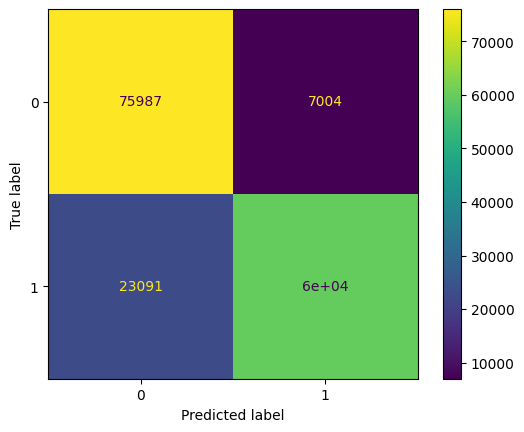

Teste: 



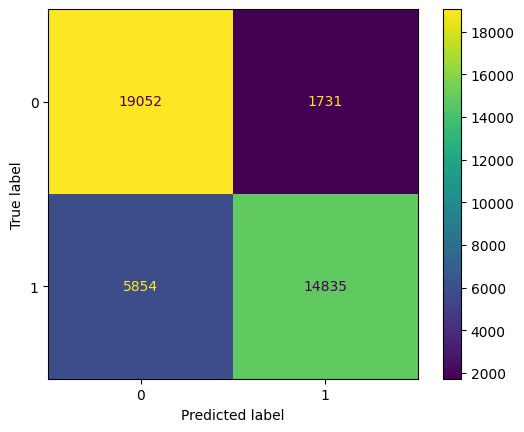

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

print("Treino: \n")
cmTreino = confusion_matrix(y_train, y_train_predictionsRF)
dispTreino = ConfusionMatrixDisplay(cmTreino)
dispTreino.plot()
plt.show()

print("Teste: \n")
cmTeste = confusion_matrix(y_test, y_test_predictionsRF)
dispTeste = ConfusionMatrixDisplay(cmTeste)
dispTeste.plot()
plt.show()

***Curva ROC***

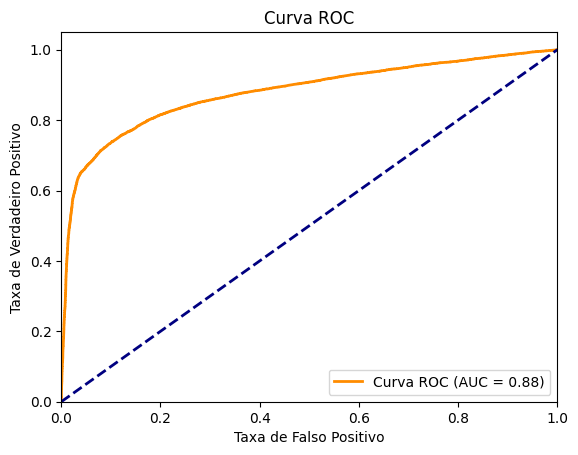

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_scores = modelRL.predict_proba(X_test_normalized)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


### **5 - K Nearest Neighbor (KNN)**

***Criar e treinar o modelo de KNN***

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Criar e treinar o modelo de KNN
modelKNN = KNeighborsClassifier()
dfModelKNN = train_model_with_KFold(modelKNN, X_train_normalized, y_train.ravel(), n_splits=10)
dfModelKNN = dfModelKNN.reset_index(drop=True)

display_side_by_side(dfModelKNN, dfModelKNN.describe(), titles=['Métricas de Avaliação','Média e Desvio Padrão'])

,Fold,Accuracy,Recall,Precision,F1_Score
0,1,0.802279,0.764137,0.826451,0.794073
1,2,0.795768,0.750663,0.824894,0.786030
2,3,0.791368,0.747147,0.821014,0.782341
3,4,0.796311,0.758231,0.821936,0.788799
4,5,0.796359,0.756698,0.819913,0.787038
5,6,0.793586,0.744750,0.825000,0.782824
6,7,0.795334,0.748293,0.828382,0.786303
7,8,0.799674,0.755025,0.825300,0.788600
8,9,0.800277,0.757160,0.829313,0.791596
9,10,0.798047,0.751298,0.828119,0.787840


***Criar e treinar o modelo de KNN***

In [ ]:
modelKNNFull = KNeighborsClassifier()
modelKNNFull.fit(X_train_normalized, y_train)

y_train_predictionsKNN = modelKNNFull.predict(X_train_normalized)
y_test_predictionsKNN = modelKNNFull.predict(X_test_normalized)

diplay_model_evaluation(y_train.ravel(), y_train_predictionsKNN.ravel(), y_test.ravel(), y_test_predictionsKNN.ravel())

,Dados,Accuracy,Recall,Precision,F1_Score
0,Treino,0.849678,0.806944,0.882186,0.842889
0,Teste,0.795187,0.750737,0.823149,0.785277


***Matriz de confusão***

Treino: 



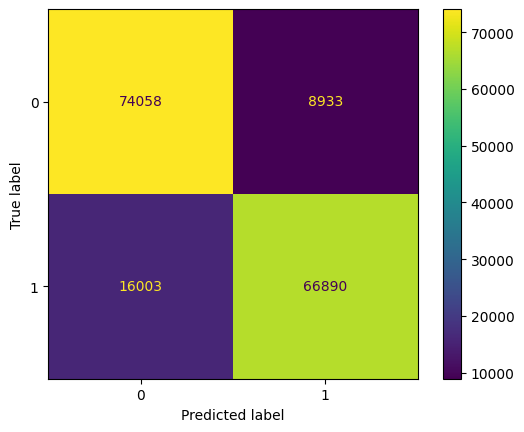

Teste: 



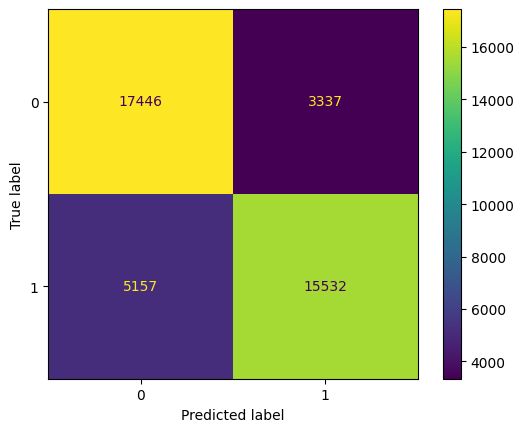

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

print("Treino: \n")
cmTreino = confusion_matrix(y_train, y_train_predictionsKNN)
dispTreino = ConfusionMatrixDisplay(cmTreino)
dispTreino.plot()
plt.show()

print("Teste: \n")
cmTeste = confusion_matrix(y_test, y_test_predictionsKNN)
dispTeste = ConfusionMatrixDisplay(cmTeste)
dispTeste.plot()
plt.show()

***Curva ROC***

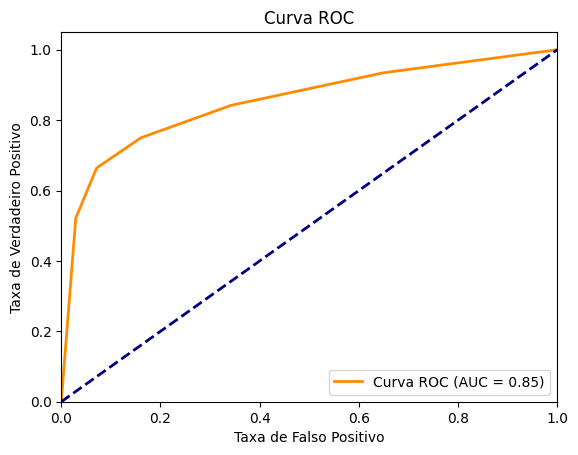

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_scores = modelKNN.predict_proba(X_test_normalized)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


### **6 - Árvores de Decisão para classificação (CART)**

***Criar e treinar o modelo de CART***

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Criar e treinar o modelo de KNN
modelCART = DecisionTreeClassifier()
dfModelCART = train_model_with_KFold(modelCART, X_train_normalized, y_train.ravel(), n_splits=10)
dfModelCART = dfModelCART.reset_index(drop=True)

display_side_by_side(dfModelCART, dfModelCART.describe(), titles=['Métricas de Avaliação','Média e Desvio Padrão'])

,Fold,Accuracy,Recall,Precision,F1_Score
0,1,0.751823,0.735259,0.759581,0.747222
1,2,0.751402,0.738963,0.757606,0.748168
2,3,0.747242,0.737177,0.753746,0.745370
3,4,0.752909,0.741168,0.760261,0.750593
4,5,0.749156,0.738999,0.752221,0.745551
5,6,0.748975,0.734854,0.755834,0.745196
6,7,0.747287,0.731161,0.758042,0.744359
7,8,0.752110,0.742112,0.753308,0.747668
8,9,0.754823,0.742960,0.761752,0.752239
9,10,0.751387,0.731248,0.761222,0.745934


***Criar e treinar o modelo de CART***

In [ ]:
modelCARTFull = DecisionTreeClassifier()
modelCARTFull.fit(X_train_normalized, y_train)

y_train_predictionsCART = modelCARTFull.predict(X_train_normalized)
y_test_predictionsCART = modelCARTFull.predict(X_test_normalized)

diplay_model_evaluation(y_train.ravel(), y_train_predictionsCART.ravel(), y_test.ravel(), y_test_predictionsCART.ravel())

,Dados,Accuracy,Recall,Precision,F1_Score
0,Treino,0.978786,0.960805,0.996621,0.978385
0,Teste,0.748915,0.735898,0.754684,0.745173


***Matriz de confusão***

Treino: 



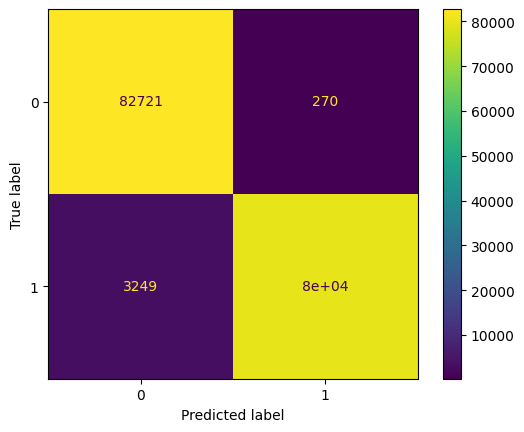

Teste: 



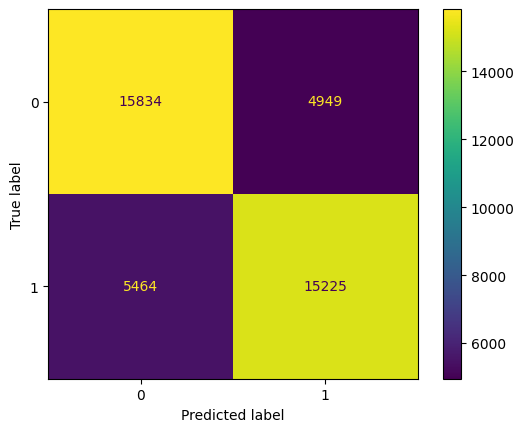

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

print("Treino: \n")
cmTreino = confusion_matrix(y_train, y_train_predictionsCART)
dispTreino = ConfusionMatrixDisplay(cmTreino)
dispTreino.plot()
plt.show()

print("Teste: \n")
cmTeste = confusion_matrix(y_test, y_test_predictionsCART)
dispTeste = ConfusionMatrixDisplay(cmTeste)
dispTeste.plot()
plt.show()

***Curva ROC***

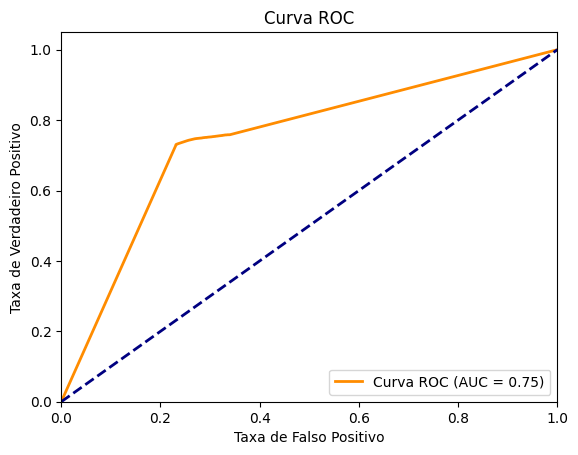

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_scores = modelCART.predict_proba(X_test_normalized)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


### **7 - Naïve Bayes - (NB)**

***Criar e treinar o modelo de NB***

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Criar e treinar o modelo de NB
modelNB = GaussianNB()
dfModelNB= train_model_with_KFold(modelNB, X_train_normalized, y_train.ravel(), n_splits=10)
dfModelNB = dfModelNB.reset_index(drop=True)

display_side_by_side(dfModelNB, dfModelNB.describe(), titles=['Métricas de Avaliação','Média e Desvio Padrão'])

,Fold,Accuracy,Recall,Precision,F1_Score
0,1,0.806679,0.746254,0.848002,0.793881
1,2,0.803786,0.740651,0.847481,0.790473
2,3,0.799265,0.735856,0.844150,0.786292
3,4,0.807764,0.747296,0.851335,0.795930
4,5,0.803593,0.739241,0.846357,0.789181
5,6,0.794972,0.731113,0.837782,0.780821
6,7,0.803231,0.739308,0.850117,0.790850
7,8,0.810164,0.745158,0.852662,0.795294
8,9,0.802327,0.739832,0.846249,0.789470
9,10,0.804618,0.737529,0.851129,0.790267


***Criar e treinar o modelo de NB***

In [ ]:
modelNBFull = GaussianNB()
modelNBFull.fit(X_train_normalized, y_train)

y_train_predictionsNB = modelNBFull.predict(X_train_normalized)
y_test_predictionsNB = modelNBFull.predict(X_test_normalized)

diplay_model_evaluation(y_train.ravel(), y_train_predictionsNB.ravel(), y_test.ravel(), y_test_predictionsNB.ravel())

,Dados,Accuracy,Recall,Precision,F1_Score
0,Treino,0.803495,0.740123,0.847319,0.790102
0,Teste,0.802445,0.737590,0.846649,0.788366


***Matriz de confusão***

Treino: 



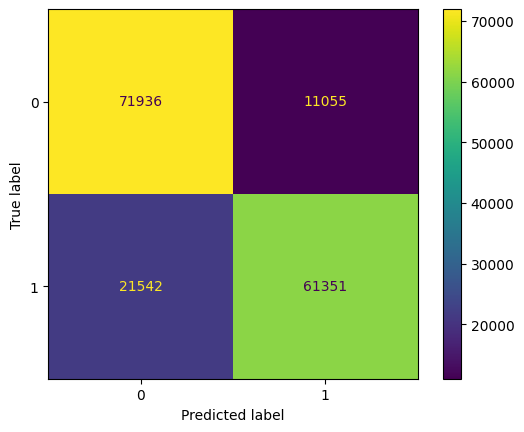

Teste: 



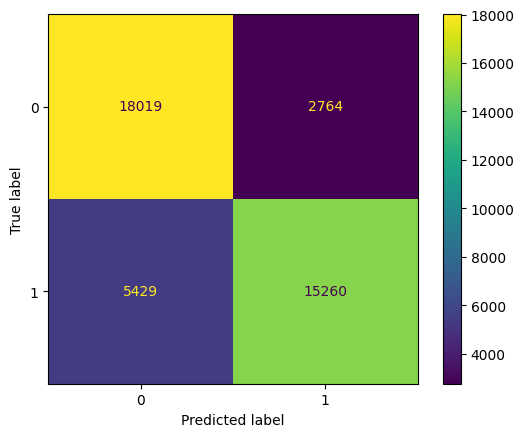

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

print("Treino: \n")
cmTreino = confusion_matrix(y_train, y_train_predictionsNB)
dispTreino = ConfusionMatrixDisplay(cmTreino)
dispTreino.plot()
plt.show()

print("Teste: \n")
cmTeste = confusion_matrix(y_test, y_test_predictionsNB)
dispTeste = ConfusionMatrixDisplay(cmTeste)
dispTeste.plot()
plt.show()

***Curva ROC***

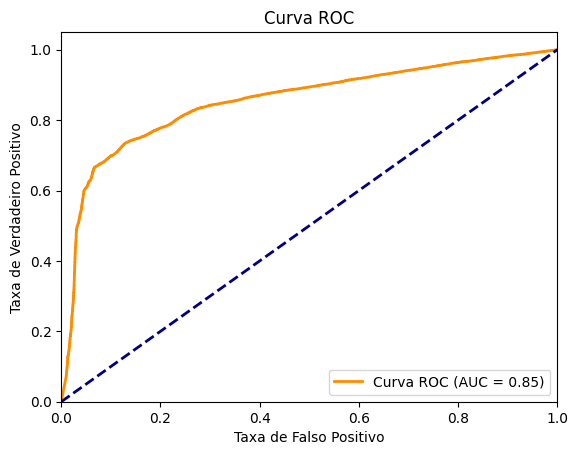

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_scores = modelNB.predict_proba(X_test_normalized)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


### **8 - Random forest**

***Criar e treinar o modelo de RF***

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Criar e treinar o modelo de KNN
modelRF = RandomForestClassifier()
dfModelRF = train_model_with_KFold(modelRF, X_train_normalized, y_train.ravel(), n_splits=10)
dfModelRF = dfModelRF.reset_index(drop=True)

display_side_by_side(dfModelRF, dfModelRF.describe(), titles=['Métricas de Avaliação','Média e Desvio Padrão'])

,Fold,Accuracy,Recall,Precision,F1_Score
0,1,0.799506,0.759667,0.824633,0.790818
1,2,0.802037,0.758866,0.830385,0.793017
2,3,0.795226,0.753634,0.823360,0.786955
3,4,0.798300,0.756068,0.827024,0.789956
4,5,0.799674,0.755849,0.826485,0.789590
5,6,0.797504,0.745354,0.831785,0.786201
6,7,0.804919,0.753924,0.841873,0.795475
7,8,0.799373,0.757705,0.822860,0.788940
8,9,0.802206,0.761131,0.829944,0.794049
9,10,0.798891,0.754197,0.827568,0.789181


***Criar e treinar o modelo de RF***

In [ ]:
modelRFFull = RandomForestClassifier()
modelRFFull.fit(X_train_normalized, y_train)

y_train_predictionsRF = modelRFFull.predict(X_train_normalized)
y_test_predictionsRF = modelRFFull.predict(X_test_normalized)

diplay_model_evaluation(y_train.ravel(), y_train_predictionsRF.ravel(), y_test.ravel(), y_test_predictionsRF.ravel())

,Dados,Accuracy,Recall,Precision,F1_Score
0,Treino,0.978750,0.966499,0.990750,0.978474
0,Teste,0.797333,0.751124,0.826772,0.787134


***Matriz de confusão***

Treino: 



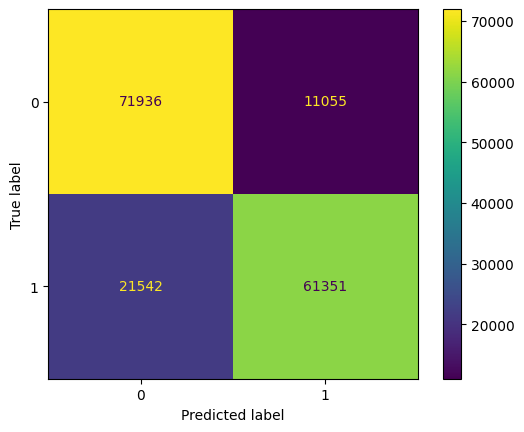

Teste: 



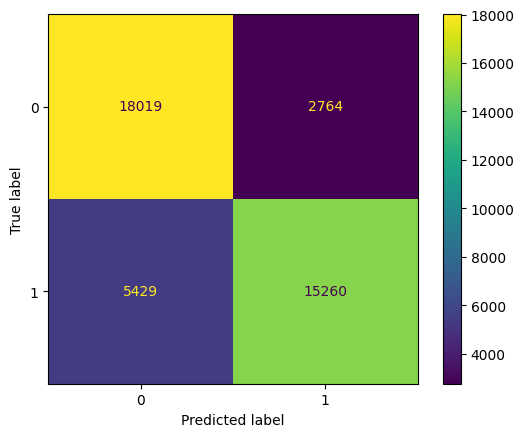

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

print("Treino: \n")
cmTreino = confusion_matrix(y_train, y_train_predictionsNB)
dispTreino = ConfusionMatrixDisplay(cmTreino)
dispTreino.plot()
plt.show()

print("Teste: \n")
cmTeste = confusion_matrix(y_test, y_test_predictionsNB)
dispTeste = ConfusionMatrixDisplay(cmTeste)
dispTeste.plot()
plt.show()

**Curva ROC**

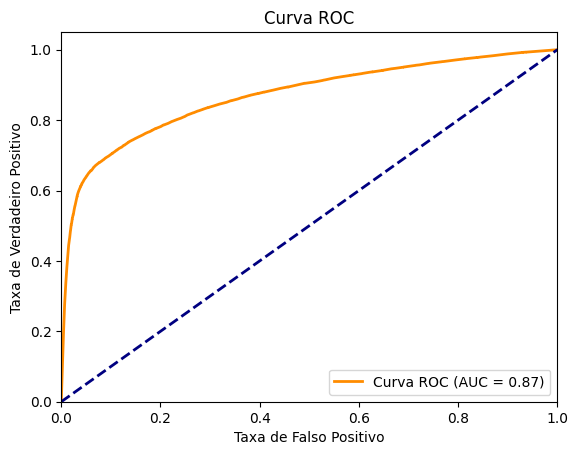

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_scores = modelRF.predict_proba(X_test_normalized)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


### **9 - Catboost**

***Criar e treinar o modelo de CB***

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool, metrics, cv

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Criar e treinar o modelo de CB
modelCB = CatBoostClassifier()
dfModelCB= train_model_with_KFold(modelCB, X_train_normalizedCB, y_trainCB.ravel(), n_splits=10)
dfModelCB = dfModelCB.reset_index(drop=True)

display_side_by_side(dfModelCB, dfModelCB.describe(), titles=['Métricas de Avaliação','Média e Desvio Padrão'])

A saída de streaming foi truncada nas últimas 5000 linhas.
4:	learn: 0.4996517	total: 403ms	remaining: 1m 20s
5:	learn: 0.4816166	total: 493ms	remaining: 1m 21s
6:	learn: 0.4675384	total: 570ms	remaining: 1m 20s
7:	learn: 0.4563556	total: 656ms	remaining: 1m 21s
8:	learn: 0.4472384	total: 745ms	remaining: 1m 22s
9:	learn: 0.4396294	total: 824ms	remaining: 1m 21s
10:	learn: 0.4341595	total: 899ms	remaining: 1m 20s
11:	learn: 0.4295247	total: 992ms	remaining: 1m 21s
12:	learn: 0.4257793	total: 1.07s	remaining: 1m 21s
13:	learn: 0.4226841	total: 1.16s	remaining: 1m 21s
14:	learn: 0.4199287	total: 1.26s	remaining: 1m 22s
15:	learn: 0.4180333	total: 1.34s	remaining: 1m 22s
16:	learn: 0.4156078	total: 1.42s	remaining: 1m 21s
17:	learn: 0.4141985	total: 1.5s	remaining: 1m 21s
18:	learn: 0.4129834	total: 1.57s	remaining: 1m 21s
19:	learn: 0.4120064	total: 1.66s	remaining: 1m 21s
20:	learn: 0.4109805	total: 1.75s	remaining: 1m 21s
21:	learn: 0.4098229	total: 1.84s	remaining: 1m 21s
22:	learn: 0

,Fold,Accuracy,Recall,Precision,F1_Score
0,1,0.824100,0.759546,0.871361,0.811620
1,2,0.822473,0.753559,0.873829,0.809249
2,3,0.817108,0.749189,0.868300,0.804359
3,4,0.821749,0.756669,0.871075,0.809851
4,5,0.821739,0.752091,0.871838,0.807550
5,6,0.817217,0.746078,0.869480,0.803066
6,7,0.822824,0.751527,0.878818,0.810203
7,8,0.824271,0.758192,0.870003,0.810258
8,9,0.821437,0.752467,0.873568,0.808508
9,10,0.820051,0.749728,0.871770,0.806156


In [ ]:
display_side_by_side(dfModelCB, dfModelCB.describe(), titles=['Métricas de Avaliação','Média e Desvio Padrão'])

,Fold,Accuracy,Recall,Precision,F1_Score
0,1,0.824100,0.759546,0.871361,0.811620
1,2,0.822473,0.753559,0.873829,0.809249
2,3,0.817108,0.749189,0.868300,0.804359
3,4,0.821749,0.756669,0.871075,0.809851
4,5,0.821739,0.752091,0.871838,0.807550
5,6,0.817217,0.746078,0.869480,0.803066
6,7,0.822824,0.751527,0.878818,0.810203
7,8,0.824271,0.758192,0.870003,0.810258
8,9,0.821437,0.752467,0.873568,0.808508
9,10,0.820051,0.749728,0.871770,0.806156


***Criar e treinar o modelo de CB***

In [ ]:
modelCBFull = CatBoostClassifier()
modelCBFull.fit(X_train_normalizedCB, y_trainCB)

y_train_predictionsCB = modelCBFull.predict(X_train_normalizedCB)
y_test_predictionsCB = modelCBFull.predict(X_test_normalizedCB)

diplay_model_evaluation(y_train.ravel(), y_train_predictionsCB.ravel(), y_test.ravel(), y_test_predictionsCB.ravel())

Learning rate set to 0.091367
0:	learn: 0.6307480	total: 95.5ms	remaining: 1m 35s
1:	learn: 0.5829599	total: 189ms	remaining: 1m 34s
2:	learn: 0.5456324	total: 284ms	remaining: 1m 34s
3:	learn: 0.5181347	total: 363ms	remaining: 1m 30s
4:	learn: 0.4954980	total: 454ms	remaining: 1m 30s
5:	learn: 0.4781063	total: 522ms	remaining: 1m 26s
6:	learn: 0.4644710	total: 607ms	remaining: 1m 26s
7:	learn: 0.4535946	total: 694ms	remaining: 1m 26s
8:	learn: 0.4445437	total: 787ms	remaining: 1m 26s
9:	learn: 0.4380716	total: 869ms	remaining: 1m 25s
10:	learn: 0.4326467	total: 952ms	remaining: 1m 25s
11:	learn: 0.4281049	total: 1.04s	remaining: 1m 26s
12:	learn: 0.4241441	total: 1.14s	remaining: 1m 26s
13:	learn: 0.4212612	total: 1.23s	remaining: 1m 26s
14:	learn: 0.4188998	total: 1.31s	remaining: 1m 26s
15:	learn: 0.4160479	total: 1.4s	remaining: 1m 26s
16:	learn: 0.4144481	total: 1.49s	remaining: 1m 26s
17:	learn: 0.4132573	total: 1.58s	remaining: 1m 26s
18:	learn: 0.4122033	total: 1.66s	remaining:

,Dados,Accuracy,Recall,Precision,F1_Score
0,Treino,0.836181,0.768087,0.888984,0.824125
0,Teste,0.819878,0.748900,0.871968,0.805762


In [ ]:
diplay_model_evaluation(y_trainCB.ravel(), y_train_predictionsCB.ravel(), y_testCB.ravel(), y_test_predictionsCB.ravel())

,Dados,Accuracy,Recall,Precision,F1_Score
0,Treino,0.836181,0.768087,0.888984,0.824125
0,Teste,0.819878,0.748900,0.871968,0.805762


***Matriz de confusão***

Treino: 



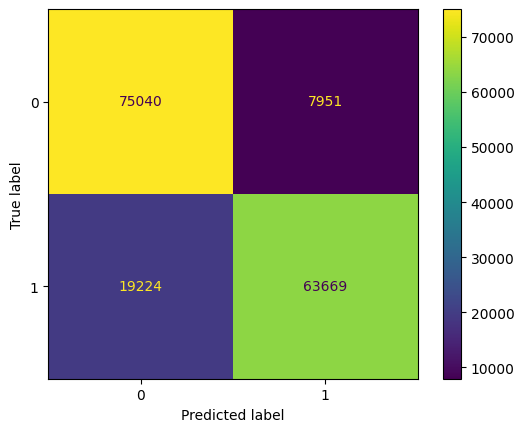

Teste: 



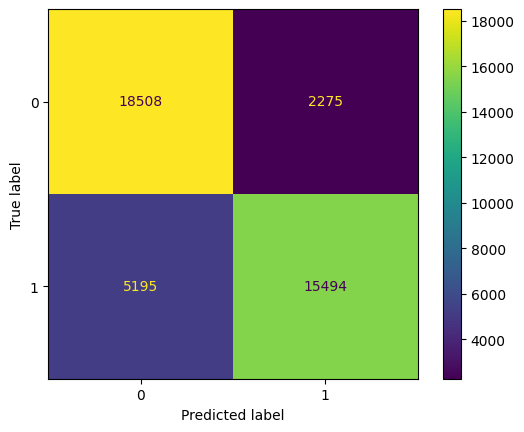

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

print("Treino: \n")
cmTreino = confusion_matrix(y_train, y_train_predictionsCB)
dispTreino = ConfusionMatrixDisplay(cmTreino)
dispTreino.plot()
plt.show()

print("Teste: \n")
cmTeste = confusion_matrix(y_test, y_test_predictionsCB)
dispTeste = ConfusionMatrixDisplay(cmTeste)
dispTeste.plot()
plt.show()

***Curvba ROC***

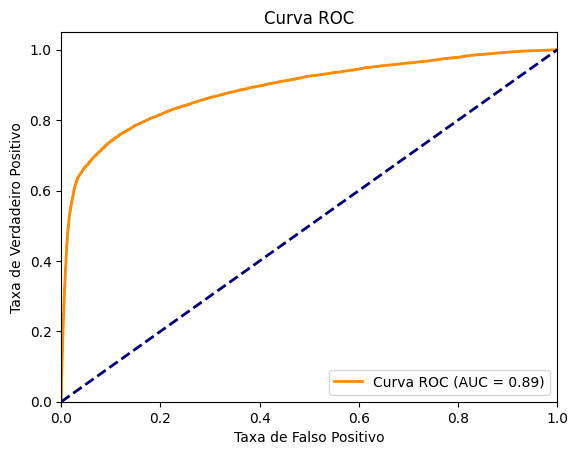

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_scores = modelCB.predict_proba(X_test_normalized)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


### **10 - Comparação dos modelos**

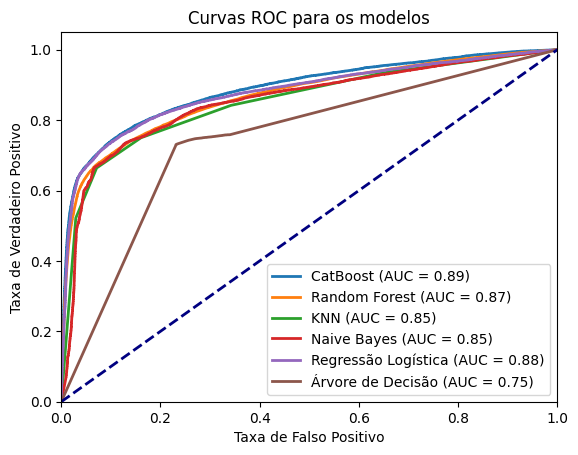

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

models = [modelCB, modelRF, modelKNN, modelNB, modelRL, modelCART]
model_names = ['CatBoost', 'Random Forest', 'KNN', 'Naive Bayes', "Regressão Logística", 'Árvore de Decisão']

plt.figure()

for model, name in zip(models, model_names):
    y_scores = model.predict_proba(X_test_normalized)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    auc = roc_auc_score(y_test, y_scores)

    plt.plot(fpr, tpr, lw=2, label='{} (AUC = {:.2f})'.format(name, auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curvas ROC para os modelos')
plt.legend(loc='lower right')
plt.show()


### **11 - Experimento Extra com If e Else**

In [17]:
# método
# gera um novo DataFrame 'y' com uma coluna de flag (0 ou 1) dependente dos valores do DataFrame 'X'
def calculaInadimplencia(X):
  # regra imaginada para que a pessoa seja adimplente em 2022, analisando 2019 a 2021
  # foi adimplente em pelo menos um ano
  # foi sócio de alguma empresa em pelo menos um ano
  # parcelou 0 ou 1 vez nos três anos

  y = ( (X['InadimplenteAno2019'] + X['InadimplenteAno2020'] + X['InadimplenteAno2021'] > 1) & (X['Parcelado2019'] + X['Parcelado2020'] + X['Parcelado2021'] > 1) & (X['ESocioAno2019'] + X['ESocioAno2020'] + X['ESocioAno2021'] < 1) )
  y = y.astype(int)

  # Criação do dataframe y com a coluna resultante
  df_y = pd.DataFrame({'InadimplenteAno2022': y})

  # print("df_y\n", df_y)
  return df_y

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split


# Definir as features (atributos de entrada)
features = ['QtdeVeiculos2019', 'ValorIPVA2019', 'ESocioAno2019', 'Parcelado2019', 'InadimplenteAno2019',
            'QtdeVeiculos2020', 'ValorIPVA2020', 'ESocioAno2020', 'Parcelado2020', 'InadimplenteAno2020',
            'QtdeVeiculos2021', 'ValorIPVA2021', 'ESocioAno2021', 'Parcelado2021', 'InadimplenteAno2021',
            'QtdeVeiculos2022', 'ValorIPVA2022', 'ESocioAno2022', 'Parcelado2022',
            'PerCapita']

# Definir a variável alvo (inadimplente)
target = 'InadimplenteAno2022'

# Separar os dados em features e variável alvo
X = dfParcelasInfoMunicipioTeste[features]
y = dfParcelasInfoMunicipioTeste[target]

# Criar e treinar o modelo de regressão logística
# divide os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dfInadimplenciaManual = calculaInadimplencia(X_test)
print("Teste: \n", classification_report(y_test, dfInadimplenciaManual))

print('\n')

dfInadimplenciaManual = calculaInadimplencia(X_train)
print("Treino: \n", classification_report(y_train, dfInadimplenciaManual))


Teste: 
               precision    recall  f1-score   support

           0       0.58      0.98      0.73     20783
           1       0.92      0.29      0.44     20689

    accuracy                           0.63     41472
   macro avg       0.75      0.63      0.58     41472
weighted avg       0.75      0.63      0.58     41472



Treino: 
               precision    recall  f1-score   support

           0       0.58      0.97      0.73     82991
           1       0.92      0.29      0.44     82893

    accuracy                           0.63    165884
   macro avg       0.75      0.63      0.58    165884
weighted avg       0.75      0.63      0.58    165884

